In [1]:
import numpy as np

### Generation of random matrix completion problems

A matrix completion problem is a problem of the form
\begin{align}
\mbox{reconstruct } & M \in\mathbb{R}^{n\times n} \\
\mbox{from } & (M_{i,j})_{(i,j) \in \Omega},
\end{align}
where $n$ is an integer and $\Omega$ is a known subset of $\{1,\dots,n\}^2$.

Without further information on $M$, this problem is ill-posed: the unobserved coefficients of $M$ can be attributed any value. Here, we make two additional assumptions:
* the rank of $M$ is smaller than some known integer $r_0$;
* $M$ is positive semidefinite.
  
The problem therefore rewrites
\begin{align}
\mbox{reconstruct } & M \in\mathbb{R}^{n\times n} \\
\mbox{from } & (M_{i,j})_{(i,j) \in \Omega}, \\
\mbox{such that } & M \succeq 0 \\
\mbox{and } & \mathrm{rank}(M) \leq r_0.
\end{align}

Our first function generates a random matrix completion problem, for given values of $n,r_0$ and cardinality of $\Omega$.

In [2]:
def completion_problem(n,r,m):
    # The unknown matrix has size nxn and rank r.
    # The number of observations (= number of elements in Omega) is m.

    # Generate M
    M = np.random.randn(n,r)
    M = M @ M.T

    # Generate Omega
    Omega = []
    while (len(Omega) < m):
        i = np.random.randint(0,n)
        j = np.random.randint(0,n)
        # Since M is symmetric, we can limit ourselves to pairs (i,j) such that i<=j.
        if (i<=j) and not((i,j) in Omega):
            Omega.append((i,j))

    meas = np.array([M[i,j] for (i,j) in Omega])
    return meas, Omega, M

### Algorithm

We consider the standard convex relaxation of the above problem:
\begin{align}
\mbox{minimize } & \mathrm{Tr}(M) \\
\mbox{over all } & M\in\mathbb{R}^{n\times n}\\
\mbox{such that } & M\succeq 0 \\
\mbox{and } & M_{i,j} = b_{i,j}, \forall (i,j) \in \Omega.
\end{align}
Here, $b$ is the vector of measurements.

In [3]:
import cvxpy as cp
import time
import scipy

In [4]:
def convex_relax(n,Omega,b):
    M = cp.Variable((n,n),symmetric=True)
    constraints = [M >> 0]
    for k in range(len(Omega)):
        constraints.append(M[Omega[k][0],Omega[k][1]] == b[k])
    t = time.time()
    prob = cp.Problem(cp.Minimize(cp.trace(M)),constraints)
    prob.solve()
    t_opt = time.time()-t
    return M.value, t_opt

In [5]:
# Quick test
n = 5
r = 1
m = 10
b, Omega, M = completion_problem(n,r,m)
M_sol,_ = convex_relax(n,Omega,b)
display(M)
display(M_sol)

array([[ 0.19128924,  0.09374309, -0.06874   ,  0.24149685,  0.96869128],
       [ 0.09374309,  0.04593968, -0.03368668,  0.1183478 ,  0.47471624],
       [-0.06874   , -0.03368668,  0.0247018 , -0.08678216, -0.34810029],
       [ 0.24149685,  0.1183478 , -0.08678216,  0.30488243,  1.22294327],
       [ 0.96869128,  0.47471624, -0.34810029,  1.22294327,  4.90546552]])

array([[ 0.19128925,  0.09374309, -0.06874   ,  0.24149685,  0.96869128],
       [ 0.09374309,  0.04593968, -0.03368775,  0.11834952,  0.47471625],
       [-0.06874   , -0.03368775,  0.02470655, -0.08678375, -0.34810029],
       [ 0.24149685,  0.11834952, -0.08678375,  0.30488243,  1.22294327],
       [ 0.96869128,  0.47471625, -0.34810029,  1.22294327,  4.90543773]])

For simplicity, in this notebook, we will limit ourselves to $r_0=1$ (but you can of course experiment with other values!).

We first investigate for which values of $n,m$ the convex relaxation is able to exactly recover the unknown matrix $M$.

In [6]:
import matplotlib.pyplot as plt

In [7]:
def empirical_rec_proba(r,ns,algo,nb_tests):

    plt.xlabel("m/nlog(n)")
    plt.ylabel("reconstruction probability")
    for n in ns:
        print("n = ", n)
        ms = [np.round(n*np.log(n)*k).astype(int) for k in np.arange(0.1,2,0.25)]
        ms = [m for m in ms if m <= n*(n+1)/2]

        nb_success = np.zeros(len(ms))
        print("  m = ", end = "")
        for k in range(len(ms)):
            print(" ",ms[k], end = "")
            for k_test in range(nb_tests):
                b, Omega, M = completion_problem(n,r,ms[k])
                M_sol = algo(n,Omega,b)
                if (np.linalg.norm(M-M_sol) < 1e-2*np.linalg.norm(M_sol)):
                    nb_success[k] += 1
        print("")
        proba_success = nb_success / nb_tests
        plt.plot(ms/n/np.log(n),proba_success,label="n="+str(n))
    plt.legend()

n =  10
  m =   2  8  14  20  25  31  37  43
n =  20
  m =   6  21  36

/home/irene/.local/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


  51  66  81  96  111
n =  30
  m =   10  36  61  87  112  138  163  189
n =  40
  m =   15  52  89  125  162  199  236  273


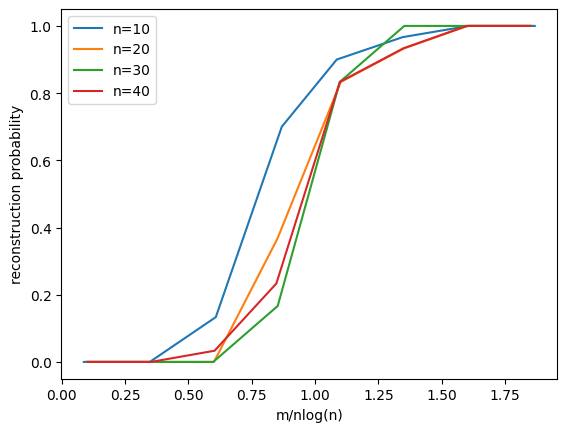

In [8]:
def algo(n,Omega,b):
    M_sol, _ = convex_relax(n,Omega,b)
    return M_sol
# Reduce the number of tests if you do not want to wait too long
nb_tests = 30
empirical_rec_proba(1,np.arange(10,45,10),algo,nb_tests)

It seems that, with probability close to $1$, the solution of the convex relaxation is the ground true matrix when $m \geq$constant$\times n\log(n)$.

Now, let us see how much time it takes to solve the convex relaxation, as a function of $n$.

n =  3
n =  6
n =  13
n =  25
n =  50
n =  100
n =  200
n =  398


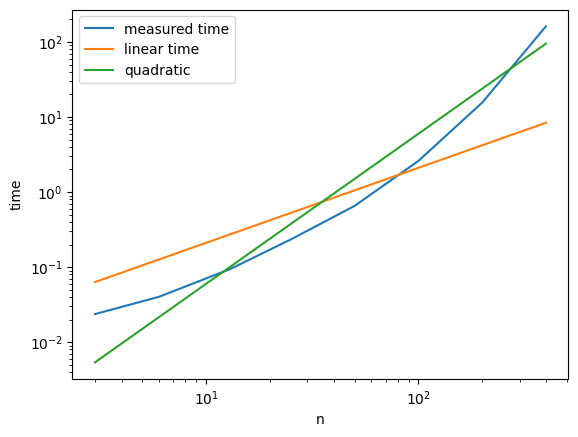

In [9]:
r = 1
# Reduce the number of tests if you do not want to wait too long
nb_tests = 30

ns = np.round(10**np.arange(0.5,2.6,0.3)).astype(int)
times = np.zeros(len(ns))
for k in range(len(ns)):
    n = ns[k]
    m = np.round(n*np.log(n)*1.8).astype(int)
    print("n = ",ns[k])

    for k_test in range(nb_tests):
        b, Omega, M = completion_problem(n,r,m)
        _, t = convex_relax(n,Omega,b)
        times[k] += t

times = times / nb_tests
plt.xlabel("n")
plt.ylabel("time")
plt.xscale("log")
plt.yscale("log")
plt.plot(ns,times,label="measured time")
plt.plot(ns,ns*scipy.stats.mstats.gmean(times/ns),label="linear time")
plt.plot(ns,ns**2*scipy.stats.mstats.gmean(times/ns**2),label="quadratic")
plt.legend()

### Burer-Monteiro factorization

Let us fix a factorization rank $p \geq r_0$. The Burer-Monteiro factorization is
\begin{align}
\mbox{minimize } & \mathrm{Tr}(UU^T) \\
\mbox{over all } & U\in\mathbb{R}^{n\times p}\\
\mbox{such that } & (UU^T)_{i,j} = b_{i,j}, \forall (i,j) \in \Omega.
\end{align}

The set $\{U\in\mathbb{R}^{n\times p}, (UU^T)_{i,j} = b_{i,j}, \forall (i,j) \in \Omega\}$
is difficult
to manipulate. Instead of having it as a constraint, it is easier to incorporate it in the objective
through a penalization term:
\begin{align}
\mbox{minimize } & F(U) \overset{def}{=}\eta \mathrm{Tr}(UU^T) + \frac{1}{2}\sum_{(i,j)\in\Omega}||(UU^T)_{i,j} - b_{i,j}||^2 \\
\mbox{over all } & U\in\mathbb{R}^{n\times p}.
\end{align}
Here, $\eta>0$ is a small real number.

In [10]:
def cost(U,eta,Omega,b):
    c = eta*np.linalg.norm(U)**2
    for k in range(len(Omega)):
        c += (np.sum(U[Omega[k][0],:] * U[Omega[k][1],:]) - b[k])**2 / 2
    return c

In [11]:
def gradient(U,eta,Omega,b):
    grad = 2*eta*U
    for k in range(len(Omega)):
        coeff = np.sum(U[Omega[k][0],:]*U[Omega[k][1],:]) - b[k]
        grad[Omega[k][0],:] += coeff * U[Omega[k][1],:]
        grad[Omega[k][1],:] += coeff * U[Omega[k][0],:]
    return grad

In [12]:
# Test if the gradient is correct
b, Omega, M = completion_problem(5,1,4)
Omega = []
eta = 0.1
U0 = np.random.randn(1)
Udot = np.random.randn(1)
print("Gradient along Udot : ", np.sum(Udot * gradient(U0,eta,Omega,b)))
ep = 1e-4
print("Finite difference approximation : ", (cost(U0+ep*Udot,eta,Omega,b) - \
    cost(U0,eta,Omega,b)) / ep)

Gradient along Udot :  -0.008863284517335146
Finite difference approximation :  -0.008863184301037552


In [13]:
def gradient_descent(Uinit,eta,Omega,b,nb_its = 100):

    # Initialize
    U = np.copy(Uinit)
    costs = np.zeros(nb_its+1)
    costs[0] = cost(U,eta,Omega,b)
    step = 0

    for k in range(nb_its):
        
        # Compute gradient
        grad = gradient(U,eta,Omega,b)
        if (k==0):
            # Initial step value
            step = 0.1 * np.linalg.norm(U) / np.linalg.norm(grad)
        # Compute next iterate
        U_test = U - step*grad
        
        # Backtrack, using Armijo-Goldstein stopping criterion
        while (cost(U_test,eta,Omega,b) > costs[k] - 0.1*step*np.linalg.norm(grad)**2):
            step = step / 2
            U_test = U - step*grad
        step = 1.1 * step

        U = U_test.copy()
        costs[k+1] = cost(U,eta,Omega,b)

    return U,costs

array([[ 0.50746885, -0.28720557, -0.30376714,  1.68009296,  1.05870033],
       [-0.28720557,  0.16254601,  0.17191915, -0.95086043, -0.5991789 ],
       [-0.30376714,  0.17191915,  0.18183278, -1.00569134, -0.63373026],
       [ 1.68009296, -0.95086043, -1.00569134,  5.56233623,  3.50507224],
       [ 1.05870033, -0.5991789 , -0.63373026,  3.50507224,  2.20869989]])

array([[ 0.48144323, -0.27709849, -0.28912023,  1.62499792,  1.01565683],
       [-0.27709849,  0.1604715 ,  0.16689498, -0.93234006, -0.58023787],
       [-0.28912023,  0.16689498,  0.17386807, -0.9743961 , -0.60777845],
       [ 1.62499792, -0.93234006, -0.9743961 ,  5.49357251,  3.44103714],
       [ 1.01565683, -0.58023787, -0.60777845,  3.44103714,  2.16168146]])

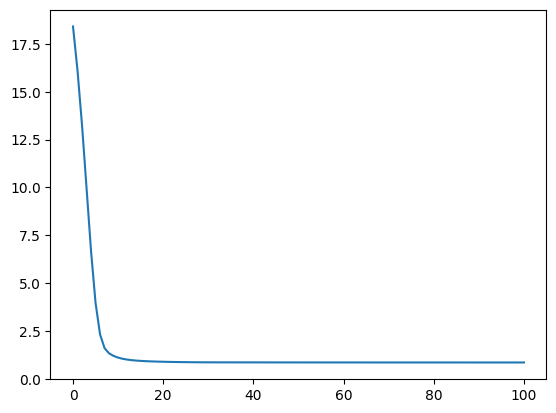

In [14]:
# Quick test
b, Omega, M = completion_problem(5,1,10)
eta = 0.1
Uinit = np.random.randn(5,2)
U,costs = gradient_descent(Uinit,eta,Omega,b)
display(M)
display(U@U.T)
plt.plot(costs)

Let us investigate the importance of $\eta$.

Distance to true solution :  1.0
Distance to true solution :  0.30160741497179416
Distance to true solution :  0.049575977739311015
Distance to true solution :  0.005774680411781414
Distance to true solution :  0.000589507153403552


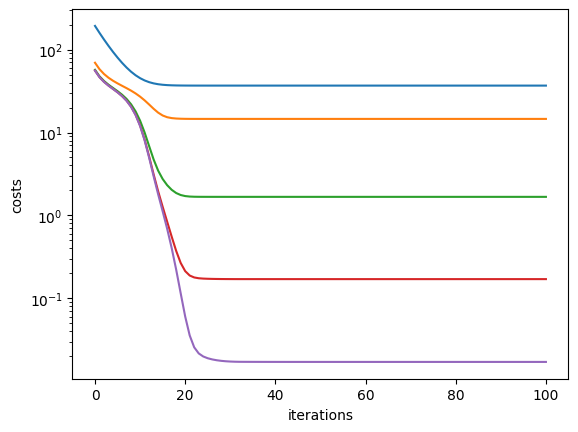

In [15]:
n = 20
r = 1
m = np.round(1.8*n*np.log(n)).astype(int)
b, Omega, M = completion_problem(n,r,m)

p = 1
Uinit = np.random.randn(n,p)

plt.xlabel("iterations")
plt.ylabel("costs")
plt.yscale("log")

for eta in np.array([1,1e-1,1e-2,1e-3,1e-4])*2*np.sqrt(m)*np.linalg.norm(b)/n:
    U,costs = gradient_descent(Uinit,eta,Omega,b)
    print("Distance to true solution : ",np.linalg.norm(M - U@U.T) / np.linalg.norm(M))
    plt.plot(costs,label="eta = " + str(eta))

It seems that the precision on the solution is proportional to $\eta$.

**Partial justification in the case $r=p$**

We assume that, for small $\eta$, the minimizer of $F$ is of the form
$$U_{\min} = (1-\alpha_{\min}) U_{opt},$$
where $U_{opt}$ is such that $U_{opt}U_{opt}^T = M$. (This assumption can be justified, but it is more complicated.)

Then $\alpha_{\min}$ must be a minimizer of
$$\min_{\alpha\in\mathbb{R}} F((1-\alpha) U_{opt}).$$
The minimizer can be explicitely computed, and we obtain
$$1-\alpha_{\min}^2 = \eta \frac{\mathrm{Tr}(U_{opt}U_{opt}^T)}{||b||^2},$$
which leads to
$$1-\alpha_{\min} \approx \eta \frac{\mathrm{Tr}(U_{opt}U_{opt}^T)}{2||b||^2},$$
when $\eta$ is small. Therefore, the relative precision is indeed proportional to $\eta$.

This suggests that, if we want to compute the solution with relative error $\epsilon$, we should choose
$$\eta \approx \frac{2||b||^2\epsilon}{\mathrm{Tr}(U_{opt}U_{opt}^T)}.$$
The value of $\mathrm{Tr}(U_{opt}U_{opt}^T) = \mathrm{Tr}(M)$ is unknown but, if we assume that all coefficients of $M$ are roughly of the same order (in absolute value), we can estimate it as
$$\mathrm{Tr}(M) = \sum_{i=1}^n |M_{ii}| \approx \sqrt{\sum_{i,j=1}^n M_{ij}^2}
\approx \sqrt{\frac{n^2}{m} ||b||^2}=\frac{n||b||}{\sqrt{m}}.$$
Therefore, a good choice of $\eta$ should be
$$\eta \approx \frac{2\sqrt{m}||b||\epsilon}{ n}.$$

n =  10
  m =   2  8  14  20  25  31  37  43
n =  20
  m =   6  21  36  51  66  81  96  111
n =  30
  m =   10  36  61  87  112  138  163  189
n =  40
  m =   15  52  89  125  162  199  236  273


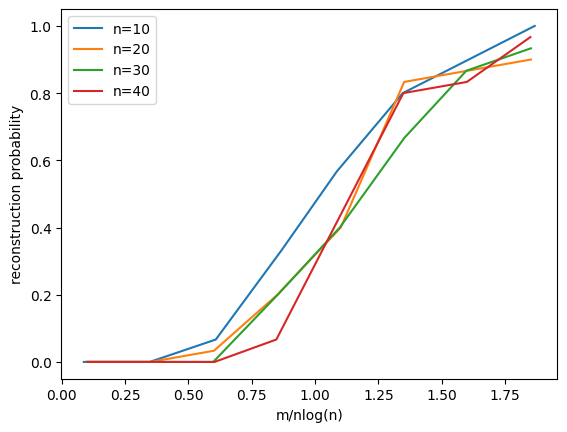

In [16]:
r = 1
p = 1

def algo(n,Omega,b):
    Uinit = np.random.randn(n,p)
    eta = 2 * np.sqrt(len(Omega)) * np.linalg.norm(b) * 1e-3 / n
    U,_ = gradient_descent(Uinit,eta,Omega,b)
    return U@U.T
    
# Reduce the number of tests if you do not want to wait too long
nb_tests = 30
empirical_rec_proba(r,np.arange(10,45,10),algo,nb_tests)

Finally, we investigate the convergence rate of gradient descent. What happens when $\eta$ and $p$ vary?

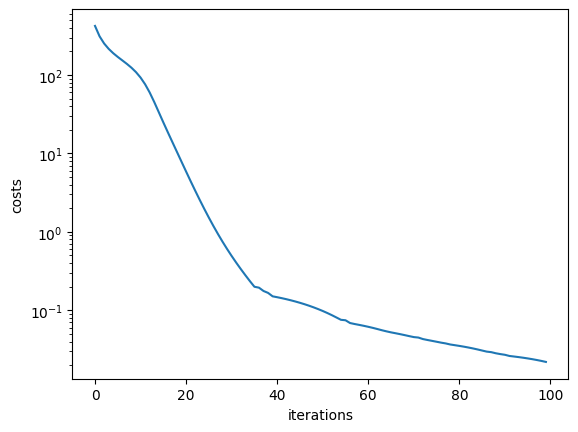

In [17]:
n = 50
r = 1
m = np.round(1.8*n*np.log(n)).astype(int)
b, Omega, M = completion_problem(n,r,m)

p = 2
Uinit = np.random.randn(n,p)
eta = 2 * np.sqrt(len(Omega)) * np.linalg.norm(b) * 1e-5 / n

nb_its = 200
U,costs = gradient_descent(Uinit,eta,Omega,b,nb_its)
plt.plot(costs[:100] - costs[-1] + 1e-12)
plt.xlabel("iterations")
plt.ylabel("costs")
plt.yscale("log")